# CNN solver for the Minesweeper game

In this notebook, we use a CNN as a DDQN to try to solve the Minesweeper game.

In [1]:
import collections
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import _LRScheduler

from env import Minesweeper

## Neural network definition

We use a convolutional neural network that preserves the size of the 2D grid it receives as an input.
The input is 9 grids which have the shape of the minesweeper grid and it outputs a single grid with the same size. The chosen action will be to uncover the tile with the maximum value in the output.

In [2]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.layer1 = nn.Conv2d(9, 32, kernel_size=3, padding=1)
        self.norm1 = nn.BatchNorm2d(32)
        self.layer2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.norm2 = nn.BatchNorm2d(64)
        self.layer3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.norm3 = nn.BatchNorm2d(128)
        self.layer4 = nn.Conv2d(128, 64, kernel_size=5, padding=2)
        self.norm4 = nn.BatchNorm2d(64)
        self.layer5 = nn.Conv2d(64, 1, kernel_size=1, padding=0)

        self.relu = F.relu

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.norm1(x)
        x = self.relu(self.layer2(x))
        x = self.norm2(x)
        x = self.relu(self.layer3(x))
        x = self.norm3(x)
        x = self.relu(self.layer4(x))
        x = self.norm4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        return x

## Environnement wrapper

We use the environnement defined in 'env.py' but we define a wrapper with several methods to have more analogies with the gymnasium environnements.

In [3]:
class MinesweeperEnvWrapper():
    def __init__(self, difficulty="beginner"):
        self.env = Minesweeper(difficulty)
        self.state = self.preprocess_state(self.env.O)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    def reset(self):
        self.env.reset()
        self.state = self.preprocess_state(self.env.O)
        return self.state
    
    def step(self, action):
        status = self.env.take_action(action)   
        self.state = self.preprocess_state(self.env.O)
        next_state = self.state
        done = bool(status)
        reward = self.reward(status)
        return next_state, reward, done
    
    def reward(self, status):
        if status == 0:  # if the model uncovers a safe tile
            return 1
        elif status == 1:  # if the model uncovers a mine
            return -50
        elif status == 2:  # if the model wins
            return 50
        else:
            raise ValueError("Invalid status")
    
    def preprocess_state(self, observed_grid):
        """Transform the observed grid into a 9xheightxwidth array which will be used as input to the CNN.

        Args:
            observed_grid (np.ndarray): Observed minesweeper grid.

        Returns:
           np.ndarray: Array of shape (9, height, width) where each channel represents a different tile value.
        """
        encoded_list = np.zeros((9, self.env.n_rows, self.env.n_cols))
        test_value_list = [0, 1, 2, 3, 4, 5, 6, 7, 8]
        for i in range(len(test_value_list)):
            # When tile is test_value_list[i] we encode it as 1, otherwise 0.
            encoded_list[i] = np.where(observed_grid == test_value_list[i], 1, 0)
        return encoded_list

## Policy definition

During the training, we will use an epsilon-greedy policy, with an epsilon decay method.

In [4]:
class EpsilonGreedy:
    def __init__(self, epsilon_start: float, epsilon_min: float, epsilon_decay:float, envWrapper: MinesweeperEnvWrapper, q_network: CNN):
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.envWrapper = envWrapper
        self.q_network = q_network
        self.device = self.envWrapper.device

    def __call__(self, state: np.ndarray) -> np.int64:
        # Only the actions corresponding to the unobserved tiles are valid
        stacked_state = np.stack(state, axis=0)
        no_ones = np.logical_not(np.any(stacked_state, axis=0))
        valid_action_indexes = np.where(no_ones)
        valid_actions_flattened = valid_action_indexes[0] * state.shape[1] + valid_action_indexes[1]

        if np.random.rand() < self.epsilon:
            action = np.random.choice(valid_actions_flattened)
        else:
            state_tensor = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
            q_values = self.q_network(state_tensor).detach().cpu().numpy().flatten()
            invalid_actions = np.delete(np.arange(q_values.size), valid_actions_flattened)
            q_values[invalid_actions] = -np.inf  # Set invalid actions to -inf
            action = np.argmax(q_values)
        return action

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

## Learning rate decay

We will also use a learning rate decay method.

In [5]:
class MinimumExponentialLR(torch.optim.lr_scheduler.ExponentialLR):
    def __init__(self, optimizer: torch.optim.Optimizer, lr_decay: float, last_epoch: int = -1, min_lr: float = 1e-6):
        self.min_lr = min_lr
        super().__init__(optimizer, lr_decay, last_epoch=last_epoch)

    def get_lr(self) -> list[float]:
        return [max(base_lr * self.gamma ** self.last_epoch, self.min_lr) for base_lr in self.base_lrs]

## Replay buffer

The replay buffer will store all training data points and we will sample points from it to train the DDQN.

In [6]:
class ReplayBuffer:
    def __init__(self, capacity: int):
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size: int):
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return np.array(states), actions, rewards, np.array(next_states), dones

    def __len__(self):
        return len(self.buffer)

## CNN Minesweeper solver

In [7]:
class Solver():
    def __init__(self, envWrapper: MinesweeperEnvWrapper, q_network: CNN, target_network: CNN):
        """Initialize the solver

        Args:
            envWrapper (MinesweeperEnvWrapper): Environment wrapper representing the Minesweeper game
            q_network (CNN): CNN Network representing the Q-network
            target_network (CNN): CNN Network representing the target network
        """
        self.envWrapper = envWrapper
        self.q_network = q_network
        self.target_network = target_network
        self.device = self.envWrapper.device

    def test_agent(self, num_episodes: int = 1) -> list[int]:  
        """Test the agent for a given number of episodes

        Args:
            num_episodes (int, optional): Number of episodes to test the agent on. Defaults to 1.

        Returns:
            list[int]: List containing the total reward for each episode.
        """
        episode_reward_list = []

        for _ in range(num_episodes):
            state = self.envWrapper.reset()
            done = False
            episode_reward = 0

            while not done:
                # Convert the state to a PyTorch tensor and add a batch dimension (unsqueeze)
                state_tensor = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
                with torch.no_grad():
                    q_values = self.q_network(state_tensor).detach().cpu().numpy().flatten()

                stacked_state = np.stack(state, axis=0)
                invalid_tiles = np.any(stacked_state, axis=0)
                invalid_actions = np.where(invalid_tiles.flatten())[0]

                q_values[invalid_actions] = -np.inf
                action = np.argmax(q_values)  # Choose the action with the highest Q-value - greedy policy           
                next_state, reward, done = self.envWrapper.step(action)               
                state = next_state
                episode_reward += reward

            episode_reward_list.append(episode_reward)
            print(f"Episode reward: {episode_reward}")

        return episode_reward_list
    
    def train_agent(
            self, 
            optimizer: torch.optim.Optimizer, 
            loss_fn: callable, 
            policy: EpsilonGreedy, 
            lr_scheduler: _LRScheduler, 
            num_episodes: int, 
            gamma: float, 
            replay_buffer: ReplayBuffer,
            target_network_sync_period: int,
            print_every: int,
            batch_size: int
    ) -> tuple[list[float]]:
        """Training loop for the agent

        Args:
            optimizer (torch.optim.Optimizer): Optimizer used to update the Q-network
            loss_fn (callable): Loss function
            policy (EpsilonGreedy): Policy used to select actions
            lr_scheduler (_LRScheduler): Learning rate scheduler
            num_episodes (int): Number of episodes to train the agent on
            gamma (float): Discount factor
            replay_buffer (ReplayBuffer): Replay buffer used to store the transitions
            target_network_sync_period (int): Number of episodes after which the target network is updated
            print_every (int): Number of episodes after which the mean reward and loss are printed
            batch_size (int): Batch size used to update the Q-network

        Returns:
            tuple[list[float]]: Tuple containing the episode reward list and the episode loss list
        """
        episode_reward_list = []
        episode_loss_list = []
        mean_reward = 0
        mean_loss = 0

        for i in range(1, num_episodes):
            state = self.envWrapper.reset()
            episode_reward = 0
            episode_loss = 0
            time_episode = 0
            done = False

            while not done:
                time_episode += 1
                action = policy(state)
                next_state, reward, done = self.envWrapper.step(action)
                episode_reward += reward

                replay_buffer.add(state, action, reward, next_state, done)
                state = next_state

            if len(replay_buffer) >= 10 * batch_size:  # Start training after the replay buffer has been filled with enough samples
                replayed_states, replayed_actions, replayed_rewards, replayed_next_states, replayed_dones = replay_buffer.sample(batch_size)
                
                replayed_states_tensor = torch.tensor(replayed_states, dtype=torch.float32, device=self.device)
                replayed_actions_tensor = torch.tensor(replayed_actions, dtype=torch.int64, device=self.device)
                replayed_rewards_tensor = torch.tensor(replayed_rewards, dtype=torch.float32, device=self.device)
                replayed_next_states_tensor = torch.tensor(replayed_next_states, dtype=torch.float32, device=self.device)
                replayed_dones_tensor = torch.tensor(replayed_dones, dtype=torch.float32, device=self.device)

                with torch.no_grad():
                    replayed_next_q_values = self.target_network(replayed_next_states_tensor)  # Use the target network to compute the next Q-values
                replayed_targets = replayed_rewards_tensor + (1-replayed_dones_tensor) * gamma * torch.max(replayed_next_q_values, dim=1).values
                replayed_q_values = self.q_network(replayed_states_tensor)  # Compute the Q-values for the replayed states with the Q-network

                replayed_actions_indices = replayed_actions_tensor.view(-1, 1)
                result = torch.gather(replayed_q_values, 1, replayed_actions_indices).squeeze(1)

                loss = loss_fn(result, replayed_targets)
                episode_loss += loss.item()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                lr_scheduler.step()
                
            
                mean_loss += loss.item() / print_every
            mean_reward += episode_reward / print_every
            
            if i % target_network_sync_period == 0:
                self.target_network.load_state_dict(self.q_network.state_dict())

            if i % print_every == 0:
                print(f"Episode: {i}, Mean reward: {mean_reward}, Epsilon: {policy.epsilon}, LR: {lr_scheduler.get_lr()[0]}, Mean loss: {mean_loss}")
                mean_reward = 0
                mean_loss = 0
            
            episode_reward_list.append(episode_reward)
            episode_loss_list.append(episode_loss / time_episode)
            policy.decay_epsilon()

        return episode_reward_list, episode_loss_list

## Training and testing of the agent

In [8]:
envWrapper = MinesweeperEnvWrapper(difficulty="beginner")
q_network = CNN().to(envWrapper.device)
target_network = CNN().to(envWrapper.device)

optimizer = torch.optim.Adam(q_network.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

epsilon_greedy = EpsilonGreedy(epsilon_start=0.9, epsilon_min=0.05, epsilon_decay=0.999, envWrapper=envWrapper, q_network=q_network)
lr_scheduler = MinimumExponentialLR(optimizer, lr_decay=0.9999, min_lr=1e-6)
buffer = ReplayBuffer(capacity=10000)

solver = Solver(envWrapper, q_network, target_network)

We train our network.

In [9]:
episode_reward_list, episode_loss_list = solver.train_agent(
    optimizer=optimizer, 
    loss_fn=loss_fn, 
    policy=epsilon_greedy, 
    lr_scheduler=lr_scheduler, 
    num_episodes=10000, 
    gamma=0.99, 
    replay_buffer=buffer, 
    print_every=500, 
    target_network_sync_period=250,
    batch_size=100
)

Episode: 500, Mean reward: -44.30799999999997, Epsilon: 0.5462873377127788, LR: 0.0009657968760541502, Mean loss: 144.550839126587
Episode: 1000, Mean reward: -44.108000000000004, Epsilon: 0.3312571394333005, LR: 0.0009186921097073094, Mean loss: 258.5647504882812
Episode: 1500, Mean reward: -43.91399999999994, Epsilon: 0.20086735468729922, LR: 0.0008738847819498909, Mean loss: 386.56971987915057
Episode: 2000, Mean reward: -44.29800000000005, Epsilon: 0.12180173459234177, LR: 0.0008312628399158793, Mean loss: 567.5261621093752
Episode: 2500, Mean reward: -42.454000000000015, Epsilon: 0.07385800730436627, LR: 0.0007907196958885078, Mean loss: 704.9810660705568
Episode: 3000, Mean reward: -42.67600000000009, Epsilon: 0.05, LR: 0.0007521539607487879, Mean loss: 872.305662109376
Episode: 3500, Mean reward: -40.120000000000054, Epsilon: 0.05, LR: 0.0007154691904245402, Mean loss: 879.8418031005863
Episode: 4000, Mean reward: -37.626000000000026, Epsilon: 0.05, LR: 0.0006805736447058546, Me

We test the agent on several episodes.

In [10]:
lst = solver.test_agent(num_episodes=10)
print(f"Mean reward: {np.mean(lst)}")

Episode reward: -41
Episode reward: -21
Episode reward: -41
Episode reward: -42
Episode reward: -35
Episode reward: -22
Episode reward: -30
Episode reward: -37
Episode reward: -20
Episode reward: -50
Mean reward: -33.9


We plot the mean reward w.r.t. the episode, using a smoothed plot.

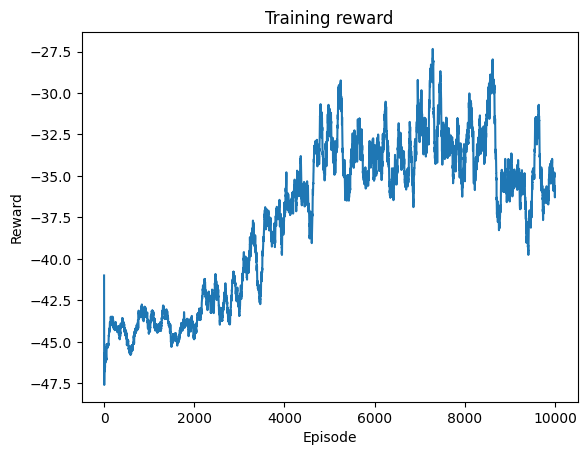

In [11]:
rewards_df = pd.DataFrame(episode_reward_list, columns=['Reward'])
N = 100
smoothed_rewards = rewards_df.rolling(window=N, min_periods=1).mean()

plt.plot(smoothed_rewards)
plt.title('Training reward')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

We can see that for the first 5,000 episodes, the model successfully trains and its performance improves. After that, its performance decreases: the loss greatly increases, and the mean reward plateaus.

In the future, we will refine the neural network architecture and tune the hyperparameters to improve the agent and allow it to successfully win the Minesweeper game.